In [1]:
import re
import string
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import DBSCAN
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from fuzzywuzzy import fuzz, process
from shapely.geometry.multipolygon import MultiPolygon

%matplotlib inline

In [2]:
h1b = pd.read_csv("../dat/clean_emp_jobs.csv")

In [4]:
# load placename data
places = pd.read_csv("../dat/ext/POP_PLACES_20171001.txt", sep="|")

In [5]:
places

,FEATURE_ID,FEATURE_NAME,FEATURE_CLASS,STATE_ALPHA,STATE_NUMERIC,COUNTY_NAME,COUNTY_NUMERIC,PRIMARY_LAT_DMS,PRIM_LONG_DMS,PRIM_LAT_DEC,PRIM_LONG_DEC,SOURCE_LAT_DMS,SOURCE_LONG_DMS,SOURCE_LAT_DEC,SOURCE_LONG_DEC,ELEV_IN_M,ELEV_IN_FT,MAP_NAME,DATE_CREATED,DATE_EDITED
0,1397658,Ester,Populated Place,AK,2,Fairbanks North Star,90.0,645050N,1480052W,64.847222,-148.014444,NaN,NaN,NaN,NaN,221.0,725.0,Fairbanks D-3,01/01/2000,01/25/2013
1,1397685,Two Rivers,Populated Place,AK,2,Fairbanks North Star,90.0,645220N,1470218W,64.872222,-147.038333,NaN,NaN,NaN,NaN,223.0,732.0,Fairbanks D-1,01/01/2000,02/04/2011
2,1397926,Afognak,Populated Place,AK,2,Kodiak Island,150.0,580120N,1524555W,58.022124,-152.765226,NaN,NaN,NaN,NaN,28.0,92.0,Afognak A-3,01/01/2000,02/10/2011
3,1397967,Aguikchuk,Populated Place,AK,2,Bethel (CA),50.0,602830N,1642608W,60.475000,-164.435556,NaN,NaN,NaN,NaN,0.0,0.0,Baird Inlet B-7,03/31/1981,NaN
4,1397989,Aiaktalik,Populated Place,AK,2,Kodiak Island,150.0,564225N,1540654W,56.706944,-154.115000,NaN,NaN,NaN,NaN,0.0,0.0,Trinity Islands C-1,03/31/1981,04/08/2010
5,1398007,Akhiok,Populated Place,AK,2,Kodiak Island,150.0,565644N,1541013W,56.945556,-154.170278,NaN,NaN,NaN,NaN,10.0,33.0,Trinity Islands D-1,01/01/2000,02/10/2011
6,1398011,Akiachak,Populated Place,AK,2,Bethel (CA),50.0,605434N,1612553W,60.909444,-161.431389,NaN,NaN,NaN,NaN,4.0,13.0,Bethel D-7,03/31/1981,05/13/2010
7,1398012,Akiak,Populated Place,AK,2,Bethel (CA),50.0,605444N,1611250W,60.912222,-161.213889,NaN,NaN,NaN,NaN,4.0,13.0,Bethel D-6,03/31/1981,05/13/2010
8,1398027,Akulurak,Populated Place,AK,2,Bethel (CA),50.0,601639N,1622629W,60.277500,-162.441389,NaN,NaN,NaN,NaN,1.0,3.0,Baird Inlet B-2,03/31/1981,NaN
9,1398028,Akulurak,Populated Place,AK,2,Kusilvak (CA),158.0,623308N,1643310W,62.552222,-164.552778,NaN,NaN,NaN,NaN,3.0,10.0,Kwiguk C-6,03/31/1981,05/13/2010


In [6]:
# make a df of only workloc1 city and state values which are unique pairs
city_state_1 = h1b.loc[:, ["lca_case_workloc1_state", "lca_case_workloc1_city"]].drop_duplicates()
city_state_2 = h1b.loc[:, ["lca_case_workloc2_state", "lca_case_workloc2_city"]].drop_duplicates()

In [7]:
city_states = pd.concat([city_state_1.rename(columns={"lca_case_workloc1_state": "state", "lca_case_workloc1_city": "city"}),
                         city_state_2.rename(columns={"lca_case_workloc2_state": "state", "lca_case_workloc2_city": "city"})]).drop_duplicates()

In [8]:
city_states.shape

(10704, 2)

In [9]:
city_states.dropna().shape

(10698, 2)

In [10]:
city_states = city_states.dropna().sort_values("state")

In [11]:
allstates = city_states.state.unique()
city_states["LAT"] = np.nan * np.ones(city_states.shape[0])
city_states["LONG"] = np.nan * np.ones(city_states.shape[0])

In [12]:
for state in allstates:
#     print(state)
    stateplaces = places.loc[places.STATE_ALPHA == state, ["FEATURE_NAME"]].values.flatten().tolist()
    cities = city_states.loc[city_states.state == state, ["city"]].values.flatten().tolist()
    place_matches = [process.extractOne(city, stateplaces) for city in cities]
    for i in range(len(cities)):
        if place_matches[i][1] >= 85:  # 85 is a good score after inspection, still a couple misses/errors though, but good enough
#             print(cities[i], place_matches[i])  # this is to check the errors
            latlong = places.loc[np.logical_and(places.STATE_ALPHA == state, places.FEATURE_NAME == place_matches[i][0]), ["PRIM_LAT_DEC", "PRIM_LONG_DEC"]]
            if latlong.shape[0] > 1:  # There are two brantleys in AL, I don't understand america
                latlong = latlong.sample()  # choose one of them at random...
            city_states.loc[np.logical_and(city_states.state == state, city_states.city == cities[i]), ["LAT", "LONG"]] = latlong.values
        

KeyboardInterrupt: 

In [63]:
# save this for now
city_states.to_csv("../dat/city_states_latlong.csv")

In [13]:
city_states = pd.read_csv("../dat/city_states_latlong.csv")

In [20]:
print(city_states.shape)
print(city_states.dropna().shape)
city_states = city_states.dropna()

(10698, 5)
(10082, 5)


In [64]:
# let's do some clustering next
# grab the latitude and longitude of the unique work locations
coordinates = city_states.loc[:, ["LAT", "LONG"]].dropna().values
# make a DBSCAN model, using max distance for points of 75 km
db = DBSCAN(eps=15/6371., min_samples=10, algorithm='ball_tree', metric='haversine')
db.fit(np.radians(coordinates))

DBSCAN(algorithm='ball_tree', eps=0.0023544184586407157, leaf_size=30,
    metric='haversine', metric_params=None, min_samples=10, n_jobs=1,
    p=None)

In [65]:
labels = db.fit_predict(np.radians(coordinates))
labels

array([-1, -1, -1, ..., -1, -1, -1])

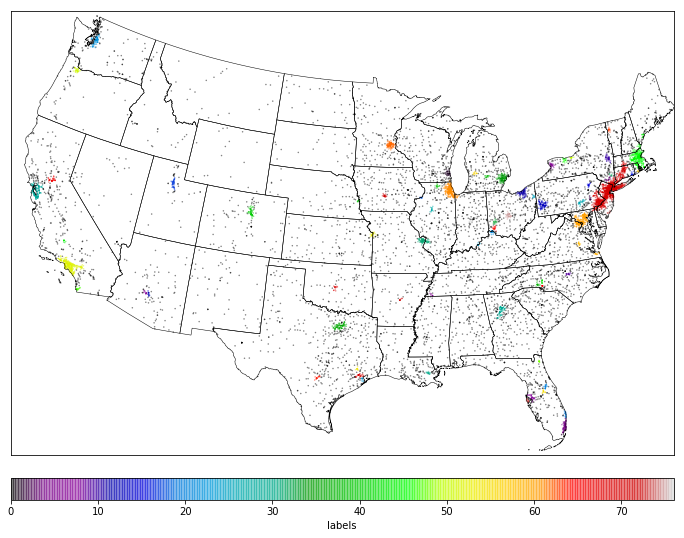

In [66]:
# shuffle labels so that clusters are more easy to distinguish
shuffled_labels = np.arange(0, len(set(labels)))
np.random.shuffle(shuffled_labels)
newlabels = np.array([shuffled_labels[l] if l >= 0 else -1 for l in labels])
                                    
nlabels = len(set(labels))
#color_list = plt.cm.Set1(np.linspace(0, 1, nlabels))
cmap = plt.cm.get_cmap('nipy_spectral')  #, nlabels + 10)
color_list = cmap(np.linspace(0, 1, nlabels))
#label_cm = matplotlib.colors.ListedColormap(color_list, nlabels)
label_colors = (1 / (nlabels - 1)) * (labels + 1)
#label_colors = [color_list[ind + 1] for ind in labels]

lllon = -119
urlon = -64
lllat = 22.0
urlat = 50.5
# and calculate a centerpoint, needed for the projection:
centerlon = float(lllon + urlon) / 2.0
centerlat = float(lllat + urlat) / 2.0
    
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

bmap = Basemap(llcrnrlon=lllon,
               llcrnrlat=lllat,
               urcrnrlon=urlon,
               urcrnrlat=urlat,
               projection='tmerc',
               lon_0=centerlon,
               lat_0=centerlat,
               ax=ax)
               # lat_1=32., lat_2=45., lon_0=-95., ax=ax) # lat_1=29.5, lat_2=45.5, ax=ax)  
bmap.readshapefile('../dat/2d_shapes', name='STATE', drawbounds=True)
bmap.drawmapboundary
ls = bmap.scatter(coordinates[:, 1],
                  coordinates[:, 0],
                  latlon=True,
                  alpha=0.5,
                  marker=".",
                  s=1,
                  c=newlabels + 1,
                  cmap=cmap)
#ls.set_array(np.linspace(0, 1, nlabels))
# cax = matplotlib.colors.ListedColormap(color_list)
#cax = matplotlib.colors.LinearSegmentedColormap.from_list("label_map", color_list, N=nlabels)
cbar = bmap.colorbar(ls, location='bottom',pad="5%")
cbar.set_label('labels')

# print(bmap(coordinates[0][0], coordinates[0][1]))
# bmap.scatter(x, y, marker='D',color='m')
# fig.show()
# x, y = bmap(coordinates[:, 0], coordinates[:, 1])
# x
# ax = plt.gca()
# ax.scatter(x, y,
#            c=labels, cmap=plt.cm.Set1, alpha=0.2)
# ax.show()

In [51]:
city_states["25km_clusters"] = labels

In [67]:
city_states.to_csv("../dat/jobloc_clusters.csv")

In [4]:
city_states = pd.read_csv("../dat/jobloc_clusters.csv")

In [5]:
# merge this information into the cleaned dataframe
print(h1b.shape)

# first rename the city_states df to have the same columns as the ones we want to match
city_states = city_states.rename(columns={"city": "lca_case_workloc1_city", "state": "lca_case_workloc1_state"})


(442910, 38)


In [7]:
h1b = h1b.merge(city_states, how="left", on=["lca_case_workloc1_city", "lca_case_workloc1_state"])

In [11]:
# and now for the workloc2 values
city_states = city_states.rename(columns={"city": "lca_case_workloc2_city", "state": "lca_case_workloc2_state"})
h1b = h1b.merge(city_states, how="left", on=["lca_case_workloc1_city", "lca_case_workloc1_state"], suffixes=["", "_2"])

In [13]:
h1b.to_csv("../dat/clean_jobloc.csv")